<a href="https://colab.research.google.com/github/shengpu-tang/RL-Off-by-a-Beat/blob/WIP/Toy_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Illustrative Example

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
%config InlineBackend.figure_formats = ['svg']
from scipy.integrate import solve_ivp

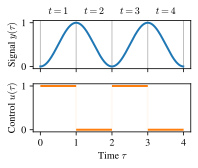

In [ ]:
# continuous time control task with sign(y'(t)) = u(t)

# Dynamics parameters
a_on = +1.0     # growth rate when control is ON
a_off = -1.0    # decay rate when control is OFF
period = 2.0    # control oscillates every 2 seconds (1s ON, 1s OFF)

def u(τ):
    # Alternates every period/2
    return int((τ % period) < (period / 2))

def dydτ(τ, y):
    return np.pi * np.sin(τ * np.pi) / 2
    # control = u(τ)
    # return a_on if control == 1 else a_off

# Time span and initial condition
t_span = (0, 3.99)
y0 = [0.0]

# Dense output for smooth plotting
solution = solve_ivp(dydτ, t_span, y0, dense_output=True, max_step=0.005)

# Plotting
tau_vals = np.linspace(*t_span, 1000)
y_vals = solution.sol(tau_vals)[0]
u_vals = [u(tau) for tau in tau_vals]

fig, axes = plt.subplots(2, 1, figsize=(3, 2.5), sharex=True)

axes[0].text(0.5, 1.2, '$t=1$', ha='center')
axes[0].text(1.5, 1.2, '$t=2$', ha='center')
axes[0].text(2.5, 1.2, '$t=3$', ha='center')
axes[0].text(3.5, 1.2, '$t=4$', ha='center')

axes[0].plot(tau_vals, y_vals, lw=2)
axes[0].grid(axis='x')
axes[1].step(tau_vals, u_vals, lw=2, color='tab:orange', alpha=0.05)
axes[1].hlines([1,0,1,0], [0,1,2,3], [1,2,3,4], lw=2, color='tab:orange')
plt.xlabel('Time $\\tau$')
axes[0].set_ylabel('Signal $y(\\tau)$')
axes[1].set_ylabel('Control $u(\\tau)$')
plt.tight_layout()
plt.savefig('toy_problem.pdf', bbox_inches='tight')
plt.show()

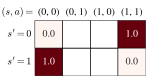

In [ ]:
P_sas = np.array([[0.0, 1.0], [np.nan, np.nan], [np.nan, np.nan], [1.0, 0.0]])
sa = [(0,0), (0,1), (1,0), (1,1)]
s_ = [0, 1]

df_P_sas = pd.DataFrame(P_sas, columns=s_, index=sa)

fig, ax = plt.subplots(figsize=(2, 3.5))
sns.heatmap(
    df_P_sas.T, ax=ax, annot=True, square=True,
    cmap='Reds', fmt='.1f', vmin=0, vmax=1, cbar=False,
    linewidths=0.5, linecolor='black', yticklabels=["$s'=0$", "$s'=1$"],
)

ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plt.tick_params(axis='x', which='both', length=0)
plt.tick_params(axis='y', which='both', length=0, rotation=0)
plt.xlabel('$(s,a) = $', )
# ax.xaxis.set_label_position('top')
ax.xaxis.set_label_coords(-0.15, 1.24)
# plt.ylabel("$s'$", rotation=0)

plt.savefig('toy_problem_transition_orig.pdf', bbox_inches='tight')
plt.show()

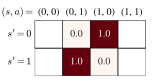

In [ ]:
P_sas = np.array([[np.nan, np.nan], [0.0, 1.0], [1.0, 0.0], [np.nan, np.nan]])
sa = [(0,0), (0,1), (1,0), (1,1)]
s_ = [0, 1]

df_P_sas = pd.DataFrame(P_sas, columns=s_, index=sa)

fig, ax = plt.subplots(figsize=(2, 3.5))
sns.heatmap(
    df_P_sas.T, ax=ax, annot=True, square=True,
    cmap='Reds', fmt='.1f', vmin=0, vmax=1, cbar=False,
    linewidths=0.5, linecolor='black', yticklabels=["$s'=0$", "$s'=1$"],
)

ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plt.tick_params(axis='x', which='both', length=0)
plt.tick_params(axis='y', which='both', length=0, rotation=0)
plt.xlabel('$(s,a) = $')
# ax.xaxis.set_label_position('top')
ax.xaxis.set_label_coords(-0.15, 1.24)
# plt.ylabel("$s'$", rotation=0)

plt.savefig('toy_problem_transition_shifted.pdf', bbox_inches='tight')
plt.show()

## Simulation Experiments

In [ ]:
import numpy as np
from tqdm import tqdm

import gymnasium as gym
from gymnasium.envs.toy_text.utils import categorical_sample
from gymnasium.wrappers import TimeLimit

from collections import defaultdict
from typing import List, Optional

In [ ]:
nS, nA = 2, 2

class ToyEnv(gym.Env):
    def __init__(self, slip_prob=0.2):
        super().__init__()
        self.nS = nS
        self.nA = nA

        self.observation_space = gym.spaces.Discrete(nS)  # 0: low, 1: high
        self.action_space = gym.spaces.Discrete(nA)       # 0: off, 1: on

        # Uniform initial state distribution
        self.isd = np.ones(nS) / nS

        # Transitions
        #   If slip, next state same as current state - should this be the opposite effect?
        #   Otherwise
        #     If action is off, next state is low
        #     If action is on,  next state is high
        # Rewards
        #
        self.P = {s: {a: [] for a in range(nA)} for s in range(nS)}
        for s in range(nS):
            for a in range(nA):
                self.P[s][a].append((slip_prob, s, float(s), False))
                if a == 0:  # off
                    self.P[s][a].append((1-slip_prob, 0, 0.0, False))
                elif a == 1:  # on
                    self.P[s][a].append((1-slip_prob, 1, 1.0, False))

        self.s = None
        self.curr_action = None

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, done = transitions[i]
        self.s = s
        self.curr_action = a

        # truncation=False as the time limit is handled by the `TimeLimit` wrapper added during `make`
        return int(s), r, done, False, {"prob": p}

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.s = int(categorical_sample(self.isd, self.np_random))
        self.curr_action = self.s  # assume last action is consistent with current state
        return self.s, {"prob": 1}

In [ ]:
def calculate_reward_function(episodes):
    R_samples = defaultdict(list)
    for ep in episodes:
        for S, A, R, S_next in ep:
            R_samples[S, A].append(R)

    R = np.zeros((nS, nA))
    for s in range(nS):
        for a in range(nA):
            R[s,a] = np.mean(R_samples[s,a])

    return R

def calculate_transition_function(episodes):
    P = np.zeros((nS, nA, nS))
    for ep in episodes:
        for S, A, R, S_next in ep:
            P[S, A, S_next] += 1

    for s in range(nS):
        for a in range(nA):
            P[s, a, :] /= np.sum(P[s, a, :])

    return P

def value_iteration(P, R, gamma=0.9, theta=1e-10):
    # VI algorithm
    V = np.zeros(nS)
    while True:
        Q = np.zeros((nS, nA))
        for s in range(nS):
            for a in range(nA):
                Q[s,a] = R[s,a] + gamma * np.sum(P[s,a,:] * V)

        V_new = np.max(Q, axis=1)
        delta = np.max(np.abs(V_new - V))
        V = V_new
        if delta < theta:
            break

    # Calculate final Q-values
    Q = np.zeros((nS, nA))
    for s in range(nS):
        for a in range(nA):
            Q[s,a] = R[s,a] + gamma * np.sum(P[s,a,:] * V)

    # Final policy with tie-breaking
    π = (Q == Q.max(axis=1, keepdims=True))
    π = π / π.sum(axis=1, keepdims=True)

    return V, Q, π

def policy_evaluation(envP, π, gamma=0.9, theta=1e-10):
    V = np.zeros(nS)
    while True:
        delta = 0
        for s in range(nS):
            v = 0
            for a, a_prob in enumerate(π[s]):
                for prob, next_state, reward, done in envP[s][a]:
                    v += a_prob * prob * (reward + (1 - done) * gamma * V[next_state])

            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        if delta < theta:
            break
    return V

## One Run - debug version

In [ ]:
env = TimeLimit(ToyEnv(slip_prob=0.2), max_episode_steps=100)

rng = np.random.default_rng(seed=0)
s, info = env.reset(seed=42)

for _ in range(20):
    a = categorical_sample(np.ones(nA)/nA, rng)
    s, r, terminated, truncated, info = env.step(a)

    if terminated or truncated:
        observation, info = env.reset()
        # print("Environment reset")

In [ ]:
# behavior policy
# prefer the action that would change the state
π_b = np.array([[0.1, 0.9], [0.75, 0.25]])

env = TimeLimit(
    ToyEnv(slip_prob=0.2),
    max_episode_steps=10,
)

num_episodes = 100
episode_data = []
rng = np.random.default_rng(seed=1000)

for ep in tqdm(range(num_episodes)):
    s, info = env.reset(seed=ep)
    episode_steps = []

    while True:
        a_curr = env.env.curr_action
        a = rng.choice(nA, p=π_b[s])
        s_next, r, terminated, truncated, info = env.step(a)
        episode_steps.append((a_curr, s, a, r, s_next))
        s = s_next

        if terminated or truncated:
            break

    episode_data.append(episode_steps)

100%|██████████| 100/100 [00:00<00:00, 1955.31it/s]


In [ ]:
episode_data[0]

[(1, 1, 0, 0.0, 0),
 (0, 0, 1, 0.0, 0),
 (1, 0, 1, 0.0, 0),
 (1, 0, 1, 1.0, 1),
 (1, 1, 0, 0.0, 0),
 (0, 0, 1, 1.0, 1),
 (1, 1, 0, 0.0, 0),
 (0, 0, 1, 1.0, 1),
 (1, 1, 0, 0.0, 0),
 (0, 0, 1, 1.0, 1)]

In [ ]:
episodes_orig = []
for ep in episode_data:
     episodes_orig.append([(s, a_curr, r, s_next) for a_curr, s, a, r, s_next in ep])

episodes_shifted = []
for ep in episode_data:
     episodes_shifted.append([(s, a, r, s_next) for a_curr, s, a, r, s_next in ep])

In [ ]:
episodes_orig[0]

[(1, 1, 0.0, 0),
 (0, 0, 0.0, 0),
 (0, 1, 0.0, 0),
 (0, 1, 1.0, 1),
 (1, 1, 0.0, 0),
 (0, 0, 1.0, 1),
 (1, 1, 0.0, 0),
 (0, 0, 1.0, 1),
 (1, 1, 0.0, 0),
 (0, 0, 1.0, 1)]

In [ ]:
episodes_shifted[0]

[(1, 0, 0.0, 0),
 (0, 1, 0.0, 0),
 (0, 1, 0.0, 0),
 (0, 1, 1.0, 1),
 (1, 0, 0.0, 0),
 (0, 1, 1.0, 1),
 (1, 0, 0.0, 0),
 (0, 1, 1.0, 1),
 (1, 0, 0.0, 0),
 (0, 1, 1.0, 1)]

In [ ]:
R_orig = calculate_reward_function(episodes_orig)
P_orig = calculate_transition_function(episodes_orig)
R_shifted = calculate_reward_function(episodes_shifted)
P_shifted = calculate_transition_function(episodes_shifted)

In [ ]:
V_orig, Q_orig, π_orig = value_iteration(P_orig, R_orig)
V_shifted, Q_shifted, π_shifted = value_iteration(P_shifted, R_shifted)

In [ ]:
R_orig

array([[0.72631579, 0.74666667],
       [0.34939759, 0.4004329 ]])

In [ ]:
R_shifted

array([[0.        , 0.80193237],
       [0.21933962, 1.        ]])

In [ ]:
P_orig

array([[[0.27368421, 0.72631579],
        [0.25333333, 0.74666667]],

       [[0.65060241, 0.34939759],
        [0.5995671 , 0.4004329 ]]])

In [ ]:
P_shifted

array([[[1.        , 0.        ],
        [0.19806763, 0.80193237]],

       [[0.78066038, 0.21933962],
        [0.        , 1.        ]]])

In [ ]:
V_orig

array([5.69274742, 5.42877135])

In [ ]:
V_shifted

array([ 9.75896531, 10.        ])

In [ ]:
Q_orig

array([[5.67723148, 5.69274742],
       [5.38986093, 5.42877135]])

In [ ]:
Q_shifted

array([[ 8.78306878,  9.75896531],
       [ 9.04999002, 10.        ]])

In [ ]:
π_orig

array([[0., 1.],
       [0., 1.]])

In [ ]:
π_shifted

array([[0., 1.],
       [0., 1.]])

## Helper functions

In [ ]:
def generate_random_behavior_policy(n_states=2, n_actions=2, seed=None):
    policy = np.random.default_rng(seed=seed).random((n_states, n_actions))
    for state in range(n_states):
        policy[state] = policy[state] / np.sum(policy[state])
    return policy

# def generate_random_behavior_policy(n_states=2, n_actions=2, seed=None):
#     policy = np.random.default_rng(seed=seed).random((1, n_actions))
#     policy = policy / np.sum(policy)
#     policy = np.repeat(policy, n_states, axis=0)
#     return policy

def generate_dataset(env, π_b, num_episodes=1, seed=None, show_progress=True):
    episode_data = []
    rng = np.random.default_rng(seed=seed)

    for ep in tqdm(range(num_episodes), disable=(not show_progress)):
        s, info = env.reset(seed=seed*1000+ep)
        episode_steps = []

        while True:
            a_curr = env.env.curr_action
            a = rng.choice(nA, p=π_b[s])
            s_next, r, terminated, truncated, info = env.step(a)
            episode_steps.append((a_curr, s, a, r, s_next))
            s = s_next

            if terminated or truncated:
                break

        episode_data.append(episode_steps)
    return episode_data

def run_experiment(episode_data):
    episodes_orig = []
    for ep in episode_data:
         episodes_orig.append([(s, a_curr, r, s_next) for a_curr, s, a, r, s_next in ep])
    episodes_shifted = []
    for ep in episode_data:
         episodes_shifted.append([(s, a, r, s_next) for a_curr, s, a, r, s_next in ep])

    R_orig = calculate_reward_function(episodes_orig)
    P_orig = calculate_transition_function(episodes_orig)
    R_shifted = calculate_reward_function(episodes_shifted)
    P_shifted = calculate_transition_function(episodes_shifted)
    V_orig, Q_orig, π_orig = value_iteration(P_orig, R_orig)
    V_shifted, Q_shifted, π_shifted = value_iteration(P_shifted, R_shifted)
    return {
        'orig': {
            'R': R_orig, 'P': P_orig, 'V': V_orig, 'Q': Q_orig, 'π': π_orig,
        },
        'shifted': {
            'R': R_shifted, 'P': P_shifted, 'V': V_shifted, 'Q': Q_shifted, 'π': π_shifted,
        }
    }

## One Run - with helper functions

In [ ]:
env = TimeLimit(
    ToyEnv(slip_prob=0.2),
    max_episode_steps=100,
)

In [ ]:
π_b = np.array([[0.1, 0.9], [0.75, 0.25]])
episode_data = generate_dataset(env, π_b, seed=0, show_progress=False)
results = run_experiment(episode_data)

In [ ]:
results['orig']['π']

array([[1., 0.],
       [0., 1.]])

In [ ]:
results['shifted']['π']

array([[0., 1.],
       [0., 1.]])

In [ ]:
π_b = generate_random_behavior_policy(2, 2, seed=3)
episode_data = generate_dataset(env, π_b, seed=42, show_progress=False)
results = run_experiment(episode_data)

In [ ]:
results['orig']['π'], results['shifted']['π']

(array([[0., 1.],
        [1., 0.]]),
 array([[0., 1.],
        [0., 1.]]))

## All Experiments

In [ ]:
MAX_EPISODES_STEPS = 100
NUM_EPISODES = 100

In [ ]:
env = TimeLimit(
    ToyEnv(slip_prob=0.2),
    max_episode_steps=MAX_EPISODES_STEPS,
)

In [ ]:
all_results = []
for run in tqdm(range(100)):
    π_b = generate_random_behavior_policy(2, 2, seed=run)
    episode_data = generate_dataset(env, π_b, num_episodes=NUM_EPISODES, seed=42, show_progress=False)
    results = run_experiment(episode_data)
    all_results.append(results)

100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


In [ ]:
# average P
avg_P_orig = np.mean([results['orig']['P'] for results in all_results], axis=0)
avg_P_shifted = np.mean([results['shifted']['P'] for results in all_results], axis=0)

In [ ]:
avg_P_orig, avg_P_shifted

(array([[[0.61328429, 0.38671571],
         [0.63596265, 0.36403735]],
 
        [[0.41836645, 0.58163355],
         [0.40120858, 0.59879142]]]),
 array([[[1.        , 0.        ],
         [0.20189564, 0.79810436]],
 
        [[0.80911208, 0.19088792],
         [0.        , 1.        ]]]))

In [ ]:
# average R
avg_R_orig = np.mean([results['orig']['R'] for results in all_results], axis=0)
avg_R_shifted = np.mean([results['shifted']['R'] for results in all_results], axis=0)

In [ ]:
avg_R_orig, avg_R_shifted

(array([[0.38671571, 0.36403735],
        [0.58163355, 0.59879142]]),
 array([[0.        , 0.79810436],
        [0.19088792, 1.        ]]))

In [ ]:
# average V
avg_V_orig = np.mean([results['orig']['V'] for results in all_results], axis=0)
avg_V_shifted = np.mean([results['shifted']['V'] for results in all_results], axis=0)

# average Q
avg_Q_orig = np.mean([results['orig']['Q'] for results in all_results], axis=0)
avg_Q_shifted = np.mean([results['shifted']['Q'] for results in all_results], axis=0)

In [ ]:
# average π_orig
avg_π_orig = np.mean([results['orig']['π'] for results in all_results], axis=0)
avg_π_shifted = np.mean([results['shifted']['π'] for results in all_results], axis=0)

In [ ]:
avg_π_orig, avg_π_shifted

(array([[0.94, 0.06],
        [0.17, 0.83]]),
 array([[0., 1.],
        [0., 1.]]))

In [ ]:
G_orig = policy_evaluation(env.env.P, avg_π_orig)
G_shifted = policy_evaluation(env.env.P, avg_π_shifted)

In [ ]:
print(G_orig.mean(), G_shifted.mean())

3.3433734931974763 9.878048779630074


## Result Figures

In [ ]:
sa = [(0,0), (0,1), (1,0), (1,1)]
s_ = [0, 1]

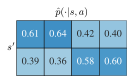

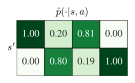

In [ ]:
df_Phat_orig = pd.DataFrame(avg_P_orig.reshape((4,2)), index=sa, columns=s_)

fig, ax = plt.subplots(figsize=(2, 1))
sns.heatmap(
    df_Phat_orig.T, ax=ax, annot=True, square=True,
    cmap='Blues', fmt='.2f', vmin=0, vmax=1, cbar=False,
    linewidths=0.5, linecolor='black', xticklabels=False, yticklabels=False,
)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plt.tick_params(axis='x', which='both', length=0)
plt.tick_params(axis='y', which='both', length=0, rotation=0)
plt.xlabel('$\hat{p}(\cdot | s,a)$')
plt.ylabel("$s'$", rotation=0)
ax.xaxis.set_label_coords(0.5, 1.24)
ax.yaxis.set_label_coords(-0.05, 0.425)
plt.savefig('synthetic_p_hat_orig.pdf', bbox_inches='tight')
plt.show()

df_Phat_shifted = pd.DataFrame(avg_P_shifted.reshape((4,2)), index=sa, columns=s_)

fig, ax = plt.subplots(figsize=(2, 3.5))
sns.heatmap(
    df_Phat_shifted.T, ax=ax, annot=True, square=True,
    cmap='Greens', fmt='.2f', vmin=0, vmax=1, cbar=False,
    linewidths=0.5, linecolor='black', xticklabels=False, yticklabels=False,
)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plt.tick_params(axis='x', which='both', length=0)
plt.tick_params(axis='y', which='both', length=0, rotation=0)
plt.xlabel('$\hat{p}(\cdot | s,a)$')
plt.ylabel("$s'$", rotation=0)
ax.xaxis.set_label_coords(0.5, 1.24)
ax.yaxis.set_label_coords(-0.05, 0.425)
plt.savefig('synthetic_p_hat_shifted.pdf', bbox_inches='tight')
plt.show()

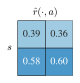

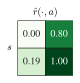

In [ ]:
df_Rhat_orig = pd.DataFrame(avg_R_orig, index=[0,1], columns=[0,1])

fig, ax = plt.subplots(figsize=(1, 1))
sns.heatmap(
    df_Rhat_orig, ax=ax, annot=True, square=True,
    cmap='Blues', fmt='.2f', vmin=0, vmax=1, cbar=False,
    linewidths=0.5, linecolor='black', xticklabels=False, yticklabels=False,
)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plt.tick_params(axis='x', which='both', length=0)
plt.tick_params(axis='y', which='both', length=0, rotation=0)
plt.xlabel('$\hat{r}(\cdot,a)$')
plt.ylabel("$s$", rotation=0)
ax.xaxis.set_label_coords(0.5, 1.24)
ax.yaxis.set_label_coords(-0.15, 0.425)
plt.savefig('synthetic_r_hat_orig.pdf', bbox_inches='tight')
plt.show()

df_Rhat_shifted = pd.DataFrame(avg_R_shifted, index=[0,1], columns=[0,1])

fig, ax = plt.subplots(figsize=(1, 1))
sns.heatmap(
    df_Rhat_shifted, ax=ax, annot=True, square=True,
    cmap='Greens', fmt='.2f', vmin=0, vmax=1, cbar=False,
    linewidths=0.5, linecolor='black', xticklabels=False, yticklabels=False,
)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plt.tick_params(axis='x', which='both', length=0)
plt.tick_params(axis='y', which='both', length=0, rotation=0)
plt.xlabel('$\hat{r}(\cdot,a)$')
plt.ylabel("$s$", rotation=0)
ax.xaxis.set_label_coords(0.5, 1.24)
ax.yaxis.set_label_coords(-0.15, 0.425)
plt.savefig('synthetic_r_hat_shifted.pdf', bbox_inches='tight')
plt.show()

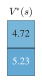

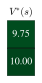

In [ ]:
df_Vhat_orig = pd.DataFrame(avg_V_orig, index=[0,1])

fig, ax = plt.subplots(figsize=(1, 1))
sns.heatmap(
    df_Vhat_orig, ax=ax, annot=True, square=True,
    cmap='Blues', fmt='.2f', vmin=0, vmax=10, cbar=False,
    linewidths=0.5, linecolor='black', xticklabels=False, yticklabels=False,
)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plt.tick_params(axis='x', which='both', length=0)
plt.tick_params(axis='y', which='both', length=0, rotation=0)
plt.xlabel('$V^{*}(s)$')
ax.xaxis.set_label_coords(0.5, 1.24)
plt.savefig('synthetic_Vstar_orig.pdf', bbox_inches='tight')
plt.show()

df_Vhat_shifted = pd.DataFrame(avg_V_shifted, index=[0,1])

fig, ax = plt.subplots(figsize=(1, 1))
sns.heatmap(
    df_Vhat_shifted, ax=ax, annot=True, square=True,
    cmap='Greens', fmt='.2f', vmin=0, vmax=10, cbar=False,
    linewidths=0.5, linecolor='black', xticklabels=False, yticklabels=False,
)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plt.tick_params(axis='x', which='both', length=0)
plt.tick_params(axis='y', which='both', length=0, rotation=0)
plt.xlabel('$V^{*}(s)$')
ax.xaxis.set_label_coords(0.5, 1.24)
plt.savefig('synthetic_Vstar_shifted.pdf', bbox_inches='tight')
plt.show()

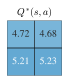

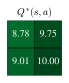

In [ ]:
df_Qhat_orig = pd.DataFrame(avg_Q_orig, index=[0,1], columns=[0,1])

fig, ax = plt.subplots(figsize=(1, 1))
sns.heatmap(
    df_Qhat_orig, ax=ax, annot=True, square=True,
    cmap='Blues', fmt='.2f', vmin=0, vmax=10, cbar=False,
    linewidths=0.5, linecolor='black', xticklabels=False, yticklabels=False,
)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plt.tick_params(axis='x', which='both', length=0)
plt.tick_params(axis='y', which='both', length=0, rotation=0)
plt.xlabel('$Q^{*}(s, a)$')
ax.xaxis.set_label_coords(0.5, 1.24)
plt.savefig('synthetic_Qstar_orig.pdf', bbox_inches='tight')
plt.show()

df_Qhat_shifted = pd.DataFrame(avg_Q_shifted, index=[0,1], columns=[0,1])

fig, ax = plt.subplots(figsize=(1, 1))
sns.heatmap(
    df_Qhat_shifted, ax=ax, annot=True, square=True,
    cmap='Greens', fmt='.2f', vmin=0, vmax=10, cbar=False,
    linewidths=0.5, linecolor='black', xticklabels=False, yticklabels=False,
)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plt.tick_params(axis='x', which='both', length=0)
plt.tick_params(axis='y', which='both', length=0, rotation=0)
plt.xlabel('$Q^{*}(s, a)$')
ax.xaxis.set_label_coords(0.5, 1.24)
plt.savefig('synthetic_Qstar_shifted.pdf', bbox_inches='tight')
plt.show()

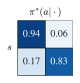

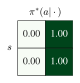

In [ ]:
df_πhat_orig = pd.DataFrame(avg_π_orig, index=[0,1], columns=[0,1])

fig, ax = plt.subplots(figsize=(1, 1))
sns.heatmap(
    df_πhat_orig, ax=ax, annot=True, square=True,
    cmap='Blues', fmt='.2f', vmin=0, vmax=1, cbar=False,
    linewidths=0.5, linecolor='black', xticklabels=False, yticklabels=False,
)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plt.tick_params(axis='x', which='both', length=0)
plt.tick_params(axis='y', which='both', length=0, rotation=0)
plt.xlabel('$\pi^{*}(a | \cdot)$')
plt.ylabel("$s$", rotation=0)
ax.xaxis.set_label_coords(0.5, 1.24)
ax.yaxis.set_label_coords(-0.15, 0.425)
plt.savefig('synthetic_pistar_orig.pdf', bbox_inches='tight')
plt.show()

df_πhat_shifted = pd.DataFrame(avg_π_shifted, index=[0,1], columns=[0,1])

fig, ax = plt.subplots(figsize=(1, 1))
sns.heatmap(
    df_πhat_shifted, ax=ax, annot=True, square=True,
    cmap='Greens', fmt='.2f', vmin=0, vmax=1, cbar=False,
    linewidths=0.5, linecolor='black', xticklabels=False, yticklabels=False,
)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plt.tick_params(axis='x', which='both', length=0)
plt.tick_params(axis='y', which='both', length=0, rotation=0)
plt.xlabel('$\pi^{*}(a | \cdot)$')
plt.ylabel("$s$", rotation=0)
ax.xaxis.set_label_coords(0.5, 1.24)
ax.yaxis.set_label_coords(-0.15, 0.425)
plt.savefig('synthetic_pistar_shifted.pdf', bbox_inches='tight')
plt.show()

In [ ]:
!zip -r fig.zip *.pdf

updating: synthetic_p_hat_orig.pdf (deflated 44%)
updating: synthetic_p_hat_shifted.pdf (deflated 46%)
updating: synthetic_pistar_orig.pdf (deflated 46%)
updating: synthetic_pistar_shifted.pdf (deflated 50%)
updating: synthetic_Qstar_orig.pdf (deflated 45%)
updating: synthetic_Qstar_shifted.pdf (deflated 46%)
updating: synthetic_Vstar_orig.pdf (deflated 52%)
updating: synthetic_Vstar_shifted.pdf (deflated 51%)
  adding: synthetic_r_hat_orig.pdf (deflated 46%)
  adding: synthetic_r_hat_shifted.pdf (deflated 49%)
